# Solving PDEs in Python using Py-PDE

There are many, many packages for solving PDEs in Python that offer a wide range of capability (and different learning curves). If you need to solve complicated PDEs on strange domains for your research, it may be worth spending time with a package such as [Fenics](https://fenicsproject.org/). However, there is a whole world of packages for solving PDEs, and it is recommended to take Earth System Modeling or more advanced courses in CSE if you are going to dive deep into the world of numerical PDE solvers (this is a whole field). In this tutorial, we will strive to cover some simple cases of PDEs you might encounter in a class or use at a basic level in research. In particular, we will use [Py-PDE](https://py-pde.readthedocs.io/en/latest/index.html), a somewhat easier-to-learn package (especially if you are not fully comfortable with PDEs and variational forms) that is handy to use for many of the sorts of basics PDEs you might encounter in Earth sciences, including: diffusion, advection, waves, etc. In general Py-PDE can solve PDEs of the form

$$ \partial_t u(x, t) = \mathcal D[u(x, t)] + \eta(u, x, t) \$$
where $\mathcal D$ is a differential operator on the function we are solving for, $u$

We start by loading in some functions from the Py-PDE package, which you can install using the directions found [here](https://py-pde.readthedocs.io/en/latest/getting_started.html)

In [1]:
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph, DiffusionPDE, UnitGrid

## A simple diffusion example

Py-PDE can specify simple version of certain common PDE's such as the basic diffusion equation and the wave equation.

In [2]:
eq = DiffusionPDE(diffusivity=0.1)  # define the pde, where the only thing to be specified is the diffusivity (0.1)

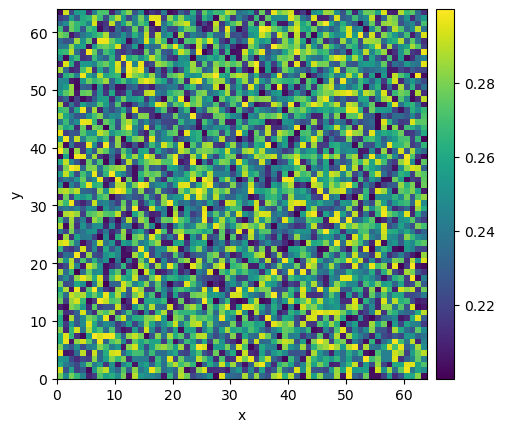

In [3]:
grid = UnitGrid([64, 64])  # generate 2D grid
state = ScalarField.random_uniform(grid, 0.2, 0.3)  # generate random initial conditions from a uniform distribution between 0.2 and 0.3
state.plot()

Initializing:   0%|          | 0/5000.0 [00:00<?, ?it/s]Explicit stepper with a fixed time step did not receive any initial value for `dt`. Using dt=0.001, but specifying a value or enabling adaptive stepping is advisable.
100%|██████████| 5000.0/5000.0 [01:00<00:00, 83.27it/s]  


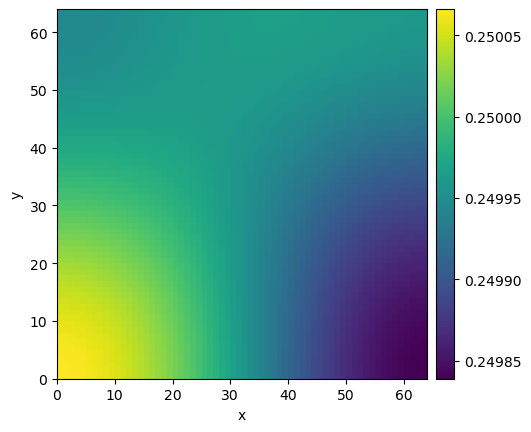

In [5]:
result = eq.solve(state, t_range=5000) #solve model until t=500
result.plot() #plot final state

## Diffusion equation with spatial-dependent diffusivity

Next, we want to define the PDE that we want to solve. We will start with a simple diffusion problem with a spatially-variable diffusivity:
$$ \frac{\partial C}{\partial t} = \nabla \left[D(x) \nabla C \right] $$
where $C$ is the evolving variable and $D(x)$ is the diffusivity that is a function of space. We can expand this equation for a more stable method to solve this equation:
$$ \frac{\partial C}{\partial t} = D \nabla^2 C + \nabla D \nabla C $$

In [6]:
diffusivity = "1.01 + tanh(x)" # define the diffusivity in terms of a tanhx function
term_1 = f"({diffusivity}) * laplace(c)" #define term 1 on the RHS (laplace is the same as nabla^2)
term_2 = f"dot(gradient({diffusivity}), gradient(c))" #define term 2 on the RHS (the dot product of these two terms)
eq = PDE({"c": f"{term_1} + {term_2}"}, bc={"value": 0}) 
#put the terms of the RHS together using the PDE function, and specify the boundary conditions (zero-dirichlet)

Define the grid (regularly-spaced cartesian) and the initial condition ($u=1$ everywhere)

In [7]:
grid = CartesianGrid([[-5, 5]], 64)  # generate grid
field = ScalarField(grid, 1)  # generate initial condition

Initiate storage of solution and solve

In [8]:
storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(field, t_range=100, dt=1e-3, tracker=storage.tracker(1))  # solve the PDE with particular t_range (final time) and time step length, and storage of solution specified

Plot the result as a function of space and time using a kymograph (aka Hovmoller u(x,t) surface plot)

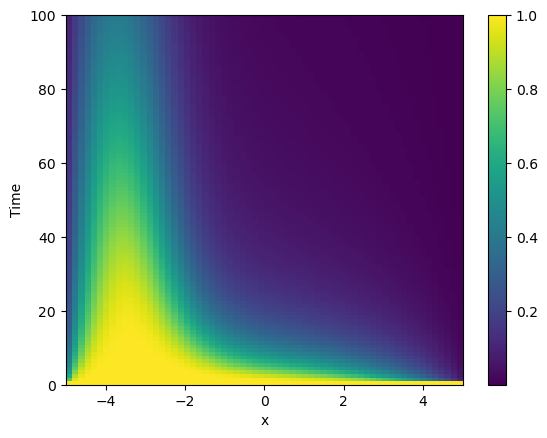

In [9]:
plot_kymograph(storage)  # visualize the result in a space-time plot

# Brusselator PDE

The [Brusselator](https://en.wikipedia.org/wiki/Brusselator) PDE is a cool variant on the classic diffusion equation where two fields "react" with each other while also diffusing. Here are the equations:
$$ \partial_t u = D_0 \nabla u + a - (1+b)u + vu^2 $$
$$ \partial_t v = D_1 \nabla v + bu - vu^2 $$

In [10]:
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid, movie

# define the PDE
a, b = 1, 3
d0, d1 = 1, 0.1
eq = PDE(
    {
        "u": f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
        "v": f"{d1} * laplace(v) + {b} * u - u**2 * v",
    }
)

# initialize state
grid = UnitGrid([64, 64])
u = ScalarField(grid, a, label="Field $u$")
v = b / a + 0.1 * ScalarField.random_normal(grid, label="Field $v$")
state = FieldCollection([u, v])

# simulate the pde
storage = MemoryStorage()  # store intermediate information of the simulation
sol = eq.solve(state, t_range=100, dt=1e-3, tracker=storage.tracker(1))

In [11]:
movie(storage, filename="Brusselator_movie.mp4")

100%|██████████| 101/101 [00:13<00:00,  7.52it/s]
